**Les librairies et import nécessaire, et donc à installer**

In [ ]:
%matplotlib inline

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,618 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
!pip install opencv-python
!pip install torch torchvision torchaudio
!pip install easyocr

     |████████████████████████████████| 63.6 MB 2.6 MB/s 
     |████████████████████████████████| 47.6 MB 142 kB/s 


In [ ]:
import time
import numpy as np
from math import *
import csv
import pandas as pd
import matplotlib.pyplot as plt
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image
import glob
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Conv2DTranspose, Input
from tensorflow.keras.callbacks import EarlyStopping
import easyocr

On obtiens la liste de toutes les images contenu dans le dossier 'content' de google Colab 

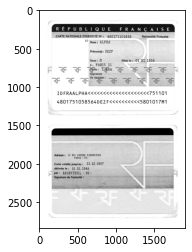

In [ ]:
#On récupère dans une liste toute notre base de donées d'images
file="/content"
ext="/"
enfant="copie"
Listedesimages = [f for f in os.listdir(file) if f.endswith(".png")]
#print(Listedesimages," ",len(Listedesimages))
Listedesimages.sort()

#Maintenant nous devons ajouter à chaque élément son path pour python puisse le trouver
ListedesimagesavecExtension=[]
for i in Listedesimages:
    ListedesimagesavecExtension.append(file+ext+i)
#print(ListedesimagesavecExtension," fff ",len(ListedesimagesavecExtension))
img = ListedesimagesavecExtension[0]

#On affiche la vrai image
def Show(img:str):
  imp=Image.open(img)
  plt.imshow(imp)
  plt.show()
Show(img)



On définis la fonction permettant de lire nos différents dataset, **le premier est le dataset des patronymes**, **le second des prénoms** (tout deux disponibles sur data.gouv) et **le troisième est un dataset de prénoms mais cette fois avec le sexe associé**. Ce troisième dataset nous permet de savoir si on a bien attribuer le bon prénom ou alors peut nous servir de correction si on trouve pas le prénom et utiliser le sexe comme information supllémentaire pour la sélection.

In [ ]:
def LireCSV():
    Patronymes=pd.read_csv(file+"/patronymes.csv",sep=',')
    Prenom=pd.read_csv(file+"/prenom.csv",sep=',')
    PrenomAvecSexe=pd.read_csv("/content/PrenomsEtSexe.csv",sep=';',encoding='latin-1')
    colonne=["01_prenom","02_genre"]
    #le genre est soit m (masculin) ou soit f (feminin)
    return Patronymes,Prenom,PrenomAvecSexe[colonne]

def Gray(img):
  image=Image.open(img)
  imagegray=image.convert('L')
  couleur='gray'
  l=img.split('.')
  imagegray.save(l[0]+couleur+l[1])
  lien=l[0]+couleur+l[1]
  return lien

def Rotation(img):
  image=Image.open(img)
  image180=image.rotate(180)
  rotation='rotation'
  l=img.split('.')
  image180.save(l[0]+rotation+l[1])
  lien=l[0]+rotation+l[1]
  return lien


On définit une classe d'individu (un individu = une image), selon un nombre aléatoire l'individu subira telle ou telle modification.

In [ ]:
class Individu:
  #Soit l'individu reste le meme soit il est modifié de manière aléatoire
    
    def __init__(self, a=None):
        pos=random.randint(0,len(ListedesimagesavecExtension)-1)
        self.a=ListedesimagesavecExtension[pos]
        change=random.randint(1,5)
        if change==1 or change==2:
          if change==1:
            self.a=Gray(self.a)
          if change==2:
            self.a=Rotation(self.a)
         
    #On retourne le nom de l'image          
    def __str__(self):
        return str(f"L'image qui constitue cet individu est :{self.a}")
    #On affiche l'image
    def display(self):
        image=Image.open(file+'/'+self.a)
        return image.show()

    def PrenomAndNom(self,Prenom,Nom,sexe):
        #utilisation des distances de leven
        PrenomAvecSexe=LireCSV()[2]

        bestprenom=self.levenshteinPrenom(Prenom)
        bestNom=self.levenshteinNom(Nom)
        for j in bestprenom:
            for i in range(len(PrenomAvecSexe["01_prenom"])):
                if PrenomAvecSexe["01_prenom"][i]==j and PrenomAvecSexe["02_genre"][i]==sexe:
                    return j,bestNom[0]
        # for i in range(len(PrenomAvecSexe["01_prenom"])):
        #     for j in bestprenom:
        #         if PrenomAvecSexe["01_prenom"][i]==j and PrenomAvecSexe["02_genre"][i]==sexe:
        #             return j,bestNom[0]
        return bestprenom[0],bestNom[0]
    def ToString(self,Prenom,Nom,sexe):
        prenom,nom=self.PrenomAndNom(Prenom,Nom,sexe)
        nl = '\n'
        return str(f"Le prenom cet individu est : {nom}  et son prenom est : {prenom}")
    

# Introduction

Tout d'abord avant d'appeler notre classe, nous devons réaliser quelques essais avec easyOCR et Tesseract afin de comprendre comme ça marche. En premier temps, nous récupérons les deux premiers dataset en variable locale. Pour le troisième dataset, nous allons le diviser en deux catégories pour l'instant (pour alléger la lecture via pandas) qui sont Hommes et Femmes (avec les prénoms qui sont commun aux deux sexes).

In [ ]:
Patronymes=pd.read_csv(file+"/patronymes.csv",sep=',')
Prenom=pd.read_csv(file+"/prenom.csv",sep=',')

PrenomavecSexe=pd.read_csv("/content/PrenomsEtSexe.csv",sep=';',encoding='latin-1')
print(Patronymes)
print(Prenom)
colonne=["01_prenom","02_genre"]
print(PrenomavecSexe[colonne])

u = ""
with open('PrenomsEtSexe.csv', newline='',encoding='latin-1') as csvfile:
     spamreader = csv.reader(csvfile, delimiter=';')
     u = pd.DataFrame(spamreader)
H=u[u[1] =='m']
Bi = u[u[1] =='m,f']
F = u[u[1] =='f']
print(H)
H = pd.concat([H,Bi])
F = pd.concat([F,Bi])
H.to_csv('hommes.csv')
F.to_csv('femmes.csv')
Hommes=pd.read_csv(file+"/hommes.csv",sep=',')
Femmes=pd.read_csv(file+"/femmes.csv",sep=',')
print(Hommes)
print(Femmes)

         patronyme  count
0          838930E      1
1                A      1
2               AA      3
3              AAA      1
4              AAB      3
...            ...    ...
879416  ZYZELEWICZ      1
879417   ZYZNAWSKA      1
879418   ZYZNAWSKI      1
879419      ZZAOUI      2
879420   ZZEPPIERI      1

[879421 rows x 2 columns]
            prenom  sum
0               AA   15
1           AAAAAA    1
2           AABAID    1
3          AABALLA    1
4       AABDELBAKI    1
...            ...  ...
209304        ZYTO    1
209305   ZYUMBYULA    2
209306  ZYUMBYULKA    1
209307    ZYUMRYUT    1
209308        ZYYA    1

[209309 rows x 2 columns]
       01_prenom 02_genre
0        aaliyah        f
1         aapeli        m
2           aapo        m
3          aaren      m f
4          aarne        m
...          ...      ...
11622        zvi        m
11623   zvonimir        m
11624  zvonimira        f
11625     zvonko        m
11626    zygmunt        m

[11627 rows x 2 columns]
        

**Partie important** :
Nous allons récupérer un dataset des mots français et qui sera utile pour la suite. On définis la fonction de Levenshtein, qui permet de connaitre la distance entre deux mots, lorsuq'on lira une image on aura pas tout le temps le mot exacte ainsi nous devons regarder dans notre liste de mots.Nous créeons aussi une méthode permmettant d'effacer les caractéres spéciaux si y'en a.

In [ ]:
from easyocr.utils import printProgressBar
#On liste le fichier texte dictionnaire mot français
Mot=open(file+"/pli07.txt", "r")
Listedesmots=[]
for f in Mot.readlines():
    Listedesmots.append(f.strip())


def levenshtein(mot1:str,mot2:str):
	ligne_i = [ k for k in range(len(mot1)+1) ]
	for i in range(1, int(len(str(mot2)) + 1)):
		ligne_prec = ligne_i
		ligne_i = [i]*(len(mot1)+1)
		for k in range(1,len(ligne_i)):
			cout = int(mot1[k-1] != str(mot2)[i-1])
			ligne_i[k] = min(ligne_i[k-1] + 1, ligne_prec[k] + 1, ligne_prec[k-1] + cout)
	return ligne_i[len(mot1)]


def levenshteinMot(Mot:str):
  beta={}
  best=[]
  h=[]
  #On prend les 5 meillerus mots
  k=5
  compteur=0
  for i in range(len(Listedesmots)):
      Mot2=Listedesmots[i]
      beta[Mot2]=levenshtein(Mot,Mot2)
      h.append(levenshtein(Mot,Mot2))
      compteur+=1
  for k, v in sorted(beta.items(), key=lambda x: x[1]):
    best.append(k)
  newbest=[]
  for i in range(0,6):
    newbest.append(best[i])
  if "NOM" in newbest:
    return "NOM"
  if "PRENOM" in newbest:
    return "PRENOM"
  if "USAGE" in newbest:
    return "USAGE"
  if "SEXE" in newbest:
    return "SEXE"       
  return newbest[0]



#supprimer les caractères speciaux, espace et ajout espace entre avant nom et prenom
def SupCaracSpe(Mot:str):
    new_string = ''.join([l for l in Mot if l.isalnum() or l == ' '])
    new_string2=new_string.replace('  ',' ')
    new_string3=new_string2.replace('Nom',' Nom')
    new_string3=new_string3.replace('Pr',' Pr')
    return new_string3



Nous essayons easyOCR sun une image donnée.

In [ ]:
img="/content/CNI3.png"
print(ListedesimagesavecExtension[0])
reader=easyocr.Reader(['fr'],gpu=False)
result=reader.readtext(img)
print(result)

Using CPU. Note: This module is much faster with a GPU.


/content/CNI - Copie.png


[([[5, 0], [90, 0], [90, 14], [5, 14]], 'R € P U B L', 0.29541962663587146), ([[105, 1], [147, 1], [147, 15], [105, 15]], 'Q U E', 0.8240286456939004), ([[221, 1], [287, 1], [287, 15], [221, 15]], 'Ç A 1 5 E', 0.299573846674633), ([[0, 20], [126, 20], [126, 28], [0, 28]], "Cartenatiurai b u iuFYtiten'", 0.016900243770818797), ([[131, 17], [193, 17], [193, 31], [131, 31]], '98765235812', 0.8792936574445827), ([[117, 33], [153, 33], [153, 47], [117, 47]], 'Hartzk', 0.16464177685878206), ([[118, 48], [142, 48], [142, 56], [118, 56]], 'usage', 0.20742673641154077), ([[149, 45], [185, 45], [185, 57], [149, 57]], 'MARTIY', 0.7395773612634766), ([[92, 58], [134, 58], [134, 66], [92, 66]], "Prenonis'", 0.2776200168133864), ([[139, 57], [179, 57], [179, 69], [139, 69]], 'chARLES', 0.6137236071481922), ([[186, 58], [212, 58], [212, 66], [186, 66]], 'JfAn', 0.21931178867816925), ([[217, 55], [253, 55], [253, 69], [217, 69]], 'PIERRE', 0.5356059435398267), ([[170, 82], [204, 82], [204, 90], [170, 

Ici à la maniere d'un KNN, on utilise une fonction de fitness (ici la distance de levenstein) puis chaque mot,nom, et prenom ont un poids ainsi on renvoi les 5 meilleurs en supposant que k=5 et on se limite au 5 voisins pourtant on utilise aussi une liste de mot particulier l=(nom,prenom,adresse...) et si un elment est dans cette liste on le renvoie automatiquement

In [ ]:
MotParticuliers=["Adresse","Prenom","Nom","Usage"]

def levenshteinPrenom(prenom:str):
       Prenom=pd.read_csv(file+"/prenom.csv",sep=',')
       beta={}
       best=[]
       #On prend les 5 meillerus mots
       k=5
       compteur=0
       for i in range(len(Prenom["prenom"])):
            Mot2=Prenom["prenom"][i]
            beta[Mot2]=levenshtein(prenom,Mot2)
       for k, v in sorted(beta.items(), key=lambda x: x[1]):
            best.append(k)
       newbest=[]
       for i in range(0,6):
          newbest.append(best[i]) 
       return newbest[0]

       
def levenshteinNom(Nom:str):
       Patronymes=pd.read_csv(file+"/patronymes.csv",sep=',')
       beta={}
       best=[]
       #On prend les 5 meilleurs mots
       k=5
       compteur=0
       for i in range(len(Patronymes["patronyme"])):
            Mot2=Patronymes["patronyme"][i]
            beta[Mot2]=levenshtein(Nom,Mot2)
       for k, v in sorted(beta.items(), key=lambda x: x[1]):
            best.append(k)
       newbest=[]
       for i in range(0,6):
          newbest.append(best[i]) 
       return newbest[0]

#On regarde dans notre dataset si on trouve le nom et que le sexe associé est le bon si non on renvoie ce qu'on avait avant de vérifier avec le sexe
def PrenomAndNom(Prenom,Nom,sexe):
        #utilisation des distances de leven
        PrenomAvecSexe=LireCSV()[2]

        bestprenom=levenshteinPrenom(Prenom)
        bestNom=levenshteinNom(Nom)
        for j in bestprenom:
            for i in range(len(PrenomAvecSexe["01_prenom"])):
                if PrenomAvecSexe["01_prenom"][i]==j and PrenomAvecSexe["02_genre"][i]==sexe:
                    return j,bestNom[0]
        return bestprenom[0],bestNom[0]

Ici, nous allons utiliser easyOCR et Pytesseract pour savoir lequel est le meilleur, dans la fonction **Essaie()** nous allons la méthode **TraitementList** qui va retourner un string composé du nom, prénom, nom d'usage et sexe d'un individu, on teste avec un exemple. L'exemple est réalisé avec Pytesseract. 

In [ ]:
img="/content/CNI3.png"

#Méthode EsayOCR
def EasyOcr(img):
  reader=easyocr.Reader(['fr'],gpu=False)
  result=reader.readtext(img)
  listss=[]
  for i in result:
    new_string = ''.join([l for l in i[1] if l.isalnum() or l == ' '])
    #new_string2=new_string.replace('  ',' ')
    listss.append(new_string)
  return listss

#Méthode Pytesseract
def Pytesseract(img:str):
  extract = pytesseract.image_to_string(Image.open(img))
  new_string = ''.join([l for l in extract if l.isalnum() or l == ' '])
  new_string2=new_string.replace('  ',' ')
  new_string3=new_string2.replace('Nom',' Nom ')
  new_string3=new_string3.replace('Pr',' Pr')
  return new_string3.split(' ')
  
def TraitementList(l:list):
  Nom=[]
  Prenom=[]
  Usage=[]
  Sexe=''
  for i in range(len(l)):
    if l[i].upper()=='NOM' and l[i+1].upper()!='USAGE':
      Nom.append(levenshteinNom(l[i+1].upper()))
    if l[i].upper()=='USAGE':
      Usage.append(levenshteinNom(l[i+1].upper()))
    elif l[i].upper()=="PRONO":
      for j in range(i+1,len(l)):
          if l[j].upper()=="SEXE" : break
          Prenom.append(levenshteinPrenom(l[j].upper()))
    elif len(l[i])==1:
      Sexe=l[i]
    nl = '\n'
  return str(f"Le nom cet individu est :{nl} {nl.join(Nom)}, {nl} Et son nom d'usage est :{nl} {nl.join(Usage)} {nl} Son ou Ses prénom(s) est (sont) :{nl} {nl.join(Prenom)} {nl} Et son sexe est :{nl} {Sexe}")


def Essaie():
  #text=Individu(img)

  #Traitement d'image ici concernant Pytesseract et EsayOcr
  
  #Utilisation de easyOCR et Pytesseract
  EOR=EasyOcr(img)
  PT=Pytesseract(img)
  
  EORsansLettres=[]
  EORavecLettres=[]
  PTsansLettres=[]
  PTavecLettres=[]
  #On Sépare d'abord les chiffres des lettres :
  for i in EOR:
    if i.isnumeric():
      EORsansLettres.append(i)
    else:
      EORavecLettres.append(i)
  for i in PT:
    if i.isnumeric():
      PTsansLettres.append(i)
    else:
      PTavecLettres.append(i)

  #Traitement Mot
  PTavecLettres.remove('')
  PTavecLettres.remove('')
  PTavecLettres.remove('')
  print("1 : ", PTavecLettres)
  print("2 : ", PTsansLettres)
  print("3 : ", EORavecLettres)
  print("4 : ", EORsansLettres)
  new=[]
  #for i in PTavecLettres:
    #new.append(levenshteinMot(i.upper()))
  #print("5",new)
  print(TraitementList(PTavecLettres))


Essaie()

Using CPU. Note: This module is much faster with a GPU.


1 :  ['aeTITENY', 'Nom', 'MARTIN', 'Nom', 'usage', 'MARTIN', 'Prono', 'CHARLES', 'JEAN', 'PIERRE', 'Sexe', 'M', 'Noe', 'ins', 'PARTS75Tale', '70etl', 'eee']
2 :  ['98765235012', '21031975']
3 :  ['R  P U B L', 'Q U E', 'Ç A 1 5 E', 'Cartenatiurai b u iuFYtiten', 'Hartzk', 'usage', 'MARTIY', 'Prenonis', 'chARLES', 'JfAn', 'PIERRE', 'Kaicie', 'PARIS 75', 'Talllr 178M', 'Siynalun', 'untuinre']
4 :  ['98765235812', '031975']
Le nom cet individu est :
 MARTIN, 
 Et son nom d'usage est :
 MARTIN 
 Son ou Ses prénom(s) est (sont) :
 CHARLES
JEAN
PIERRE 
 Et son sexe est :
 M


Ici, on va tester EsayOcr avec une image composé d'un recto-verso sur une même image. et onretourne aussi cce que l'on obtient avec Pytesseract.

In [ ]:

img2="/content/CNI.jpg"
reader=easyocr.Reader(['fr'],gpu=False)
result=reader.readtext(img2)
listss=[]
for i in result:
   new_string = ''.join([l for l in i[1] if l.isalnum() or l == ' '])
    #new_string2=new_string.replace('  ',' ')
   listss.append(new_string)
print(listss)
print("\n")
print(Pytesseract(img2))

Using CPU. Note: This module is much faster with a GPU.


['R É P U B L I Q U E', 'F R A N Ç A 1 S E', 'CARTE NATIONALE DIDENTITÉ No ', '480175105856', 'Nationalite Française', 'AD', 'Nom', 'ALPHA', 'Prénoms  DEZF', 'Sexe', 'M', 'Néle le', '01011958', 'a 2', 'PARIS', '11', 'RF   RF', 'lle', 'DEm', 'RF ', 'RF RF RF', 'Signature', 'du', '0', 'RF   rF', 'RF', 'tigpe', 'RF', 'RF', 'IDFRAALPHA', '751101', '4801751058564DEZF5801017M1', 'Adresse', '13', 'BIS', 'AVENUE', 'PARMENIIER', 'PARIS', '75', 'Carte valable jusqu au', '31121957', 'délivrée le ', '01011948', 'Par ', 'ARGENTEUIL', '95', 'Signature de lautorite ', 'KRF', '31']


['', '', '', 'as', '3', 'ae', 'UB', 'BLIQUE', 'FR', 'ane', 'AISESe', 'NATIONALE', 'DIDENTITE', 'N', '480175105856', 'Nationalité', 'FrancaiseAD', 'Wom', 'ALPHA', '', 'Prénomis', 'DEZFSexe', 'M', 'Néje', '1', 'JE', '1958ars', 'PARIS', 'QF', 'RE', 'Bf', 'Ra', 'QE', 'QE', 'RE', 'BeSignatureiIDFRAALPHA7511014801751058564DEZF5801017M1Adresse', '13', 'BIS', 'AVENUE', 'PARMENTIERPARIS', '75Carte', 'valable', 'jusquau', '31121957

Avec la même image, nous allons la mettre en noir et blanc afin de savoir si cela peut nous aider à mieux lire l'image.

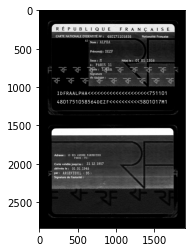

Using CPU. Note: This module is much faster with a GPU.


['R É P U B L I Q U E', 'F R A N Ç A  S E', 'CARTE NATIONALE DIDENTITÊ No ', '480175105856', 'Nationalite Française', 'AD', 'Nom', 'ALPHA', 'Prénomls  DEZF', 'Sexe', 'M', 'Néle Ie', '01011958', 'à', 'PARIS', '11', 'RF   RF', 'ZiEle', 'REn', 'RF ', 'RF   RF RF', 'Signature', 'du', '8', 'RF   RF', 'RF', 'fe', 'RF', 'RF', 'RF', 'RF', 'IDFRAALPHA', '751101', '4801751058564DEZF', '5801017M1', 'Adresse', '13', 'BIS', 'AVEWUE PARMENTIER', 'PARIS', '75 ', 'Carte valable jusquau ', '31121957', 'délivrée le ', '01011948', 'Par', 'ARGENTEUIL', '95', 'Signature de lautorite ', 'e', 'e', '215']


['', '', '', '', 'RE', 'OU', 'BLIQUE', 'FR', 'N', 'AISE', 'Rice', 'DIDENTITE', 'N', '480175105856', 'Nationalité', 'TTSike', 'r', 'ees', 'Va', 'ase', 'ls', 'Prénoms', 'DEZFToy', 'ea', 'mee', 'es', 'saeas', 'PARIS', 'MR', 'esSeara', 'aIDFRAALPHA7511014801751058564DEZ', 'F5801017M1Adresse', '13', 'BIS', 'AVENUE', 'PARMENTIERPARIS', '75Carte', 'valable', 'jusquau', '31121957délivrée', 'te', '01011948', 'par',

In [ ]:
newimg=cv2.imread(img2)
plt.imshow(newimg)
inverted_image = cv2.bitwise_not(newimg)
cv2.imwrite("/content/inverted.jpg", inverted_image)
img3="/content/inverted.jpg"
Show(img3)
reader=easyocr.Reader(['fr'],gpu=False)
result=reader.readtext(img3)
listss=[]
for i in result:
   new_string = ''.join([l for l in i[1] if l.isalnum() or l == ' '])
    #new_string2=new_string.replace('  ',' ')
   listss.append(new_string)
print(listss)
print("\n")
print(Pytesseract(img3))

**Binarization**

Pour la partie binarization, nous allons une image tester la version noir et blanc et binary via threshold la méthode de cv2.

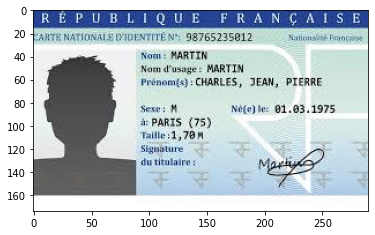

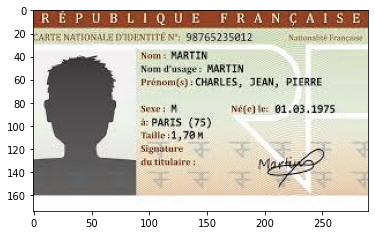

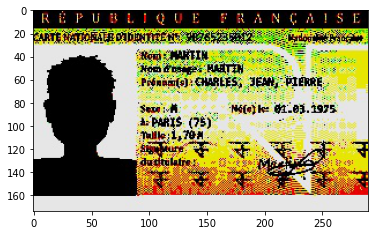

In [ ]:
import cv2
from matplotlib import pyplot as plt
img="/content/CNI3.png"
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread(img)
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
cv2.imwrite("/content/gray.jpg", gray_image)
thresh, im_bw = cv2.threshold(gray_image, 210, 230, cv2.THRESH_BINARY)
cv2.imwrite("/content/bw_image.jpg", im_bw)
Show("CNI3.png")
Show("gray.jpg")
Show("bw_image.jpg")


***Noise*** Removal

Pour celle-ci nous allons voir si via medianBlur notamment si on peut rendre l'image plus net en enlevant le bruit (comme le flou etc)

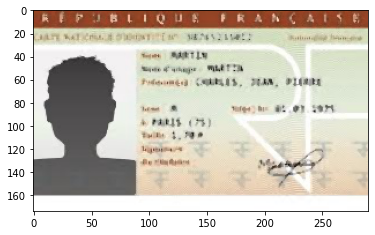

In [ ]:
def NoiseRemoval(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)
no_noise = NoiseRemoval(gray_image)
cv2.imwrite("no_noise.jpg", no_noise)
Show("no_noise.jpg")

Déterminons maitenant, la taille de notre image.

Image shape: 174H x 290W x 3C
Image shape: 194H x 310W x 3C


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


True

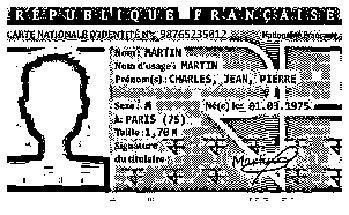

In [ ]:
img = cv2.imread(
  filename='CNI3.png',
  flags=cv2.IMREAD_COLOR,
)

h, w, c = img.shape
print(f'Image shape: {h}H x {w}W x {c}C')

img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2RGB)



Essayon de lire l'image sans bruit. Et on voit que c'est catastrophique, ça ne marche pas du tout dans notre cas. Certainment une erreur dans la méthode et comment on l'applique.

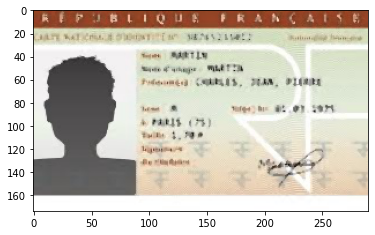

   

oe ae
mee evnage MMT
Framonkey SURES, AR, OLR

 

Saale 0)
ogy
. Mea

 



In [ ]:
def NoiseRemoval(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)
no_noise = NoiseRemoval(gray_image)
cv2.imwrite("no_noise.jpg", no_noise)
Show("no_noise.jpg")
imgt = Image.open("no_noise.jpg")
ocr_result = pytesseract.image_to_string(imgt)
print(ocr_result)


Essayons sur une image d'appliquer différents filtres et d'essayer de la lire et de voir ce qu'on pourrait avoir.

In [ ]:
image = cv2.imread("CNI3.png")
base_image = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite("index_gray.png", gray)
blur = cv2.GaussianBlur(gray, (7,7), 0)
cv2.imwrite("index_blur.png", blur)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cv2.imwrite("index_thresh.png", thresh)
kernal = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 13))
cv2.imwrite("index_kernal.png", kernal)
dilate = cv2.dilate(thresh, kernal, iterations=1)
cv2.imwrite("index_dilate.png", dilate)
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cents[1]
cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])

results  = []
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    roi = image[y:y+h, x:x+h]
    cv2.rectangle(image, (x, y), (x+w, y+h), (36, 255, 12), 2)
    ocr_result = pytesseract.image_to_string(roi)
    ocr_result = ocr_result.split("\n")
    for item in ocr_result:
          results.append(item)
cv2.imwrite("index_bbox_new.png", image)
print(results)

entities = []
for item in results:
    item = item.strip().replace("\n", "")
    item = item.split(" ")[0]
    if len(item) > 2:
        if item[0] == "A" and "-" not in item:
            item = item.split(".")[0].replace(",", "").replace(";", "")
    entities.append(item)

print(entities)
entities = list(set(entities))
print(entities)
entities.sort()
print (entities)

['esi:', 'Frénons', '', 'bs PARTS', 'alle:3,', '\x0c', 'REPUE', '', 'i', '\x0c', ' ', '', ' ', '\x0c', 'par', '\x0c', '3)', 'an', '\x0c', '\x0c', '\x0c', 'EAN', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '975', '\x0c']
['esi:', 'Frénons', '', 'bs', 'alle:3,', '', 'REPUE', '', 'i', '', '', '', '', '', 'par', '', '3)', 'an', '', '', '', 'EAN', '', '', '', '', '', '', '', '', '975', '']
['Frénons', '', '975', 'i', 'esi:', '3)', 'par', 'an', 'REPUE', 'alle:3,', 'EAN', 'bs']
['', '3)', '975', 'EAN', 'Frénons', 'REPUE', 'alle:3,', 'an', 'bs', 'esi:', 'i', 'par']


**Pour finit, on remarque que EasyOCR et Pytesseract** donnent de meilleurs résultats. Ainsi, il faut qu'on se concentre sur ces deux modules et approndire nos fonction de réduction de bruit aussi par exemple.

**Partie Signature :** Maintenant imaginons que sur image (ça ne marche qu'avec une image recto) qu'on souhaite aussi retourner la signature.

Transformons l'image en noir et blanc afin d'avoir une meilleur contraste et faire ressortir les caractères noir.

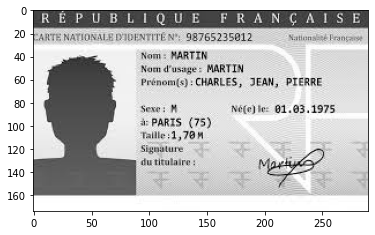

In [ ]:
import imutils
img3="/content/inverted.jpg"
img = cv2.imread(
  filename='CNI3.png',
  flags=cv2.IMREAD_COLOR,
)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

Avec l'application d'un filitre bilatéral, on retourne l'image composé seulement des caractères (sans couleurs).

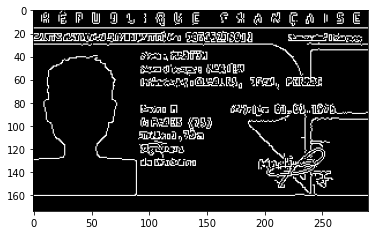

In [ ]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

On déterminer la zone où se trouve cette signature.

In [ ]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
print(len(contours))

10


In [ ]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

On retourne finalment l'image qu'avec la signature.

In [ ]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, contours, 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

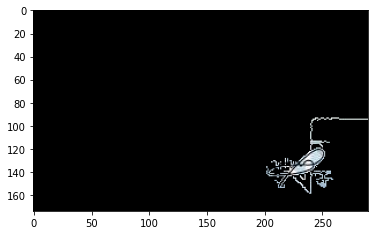

In [ ]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))


On retourne aussi l'image de la signature mais cette fois-ci avec l'image en noir et blanc précédente afin de mieux la voir.

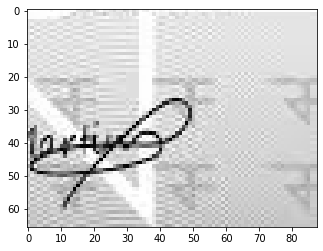

In [ ]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

**Traitement image** : essayons aussi ici d'appliquer sous différentes manières le traitment d'image et de renvoyer le text qu'on peut y lire.

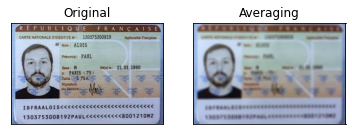

In [ ]:
img="CNI3.png"
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('CNI7.png')
kernel = np.ones((5,5),np.float32)/25
dst = cv.filter2D(img,-1,kernel)
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.show()

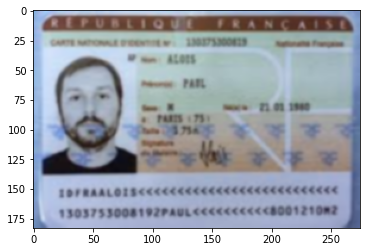

In [ ]:
blur = cv.GaussianBlur(img,(5,5),0)
plt.imshow(blur)

 

 

   

CemEMeNE OEM: TOS7SROOE naa re
en ALOIS

     
  

een PHBL

  

ao
eatin ye See

         
 
 

 

EDFRAALOIS <<< £££ <<< 6 EK<EEEEEEEEE
1303753008192PAUL<<<<<<<<<<8001210N2



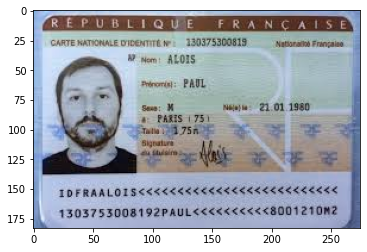

In [ ]:
median = cv.medianBlur(img,1)
plt.imshow(median)
print(pytesseract.image_to_string(img))